# <b><span style='color:#F1A424'>|</span> Image Type: <span style='color:#F1A424'>Multi-class Classification</span><span style='color:#ABABAB'> [Train]</span></b> 

***


### <b><span style='color:#F1A424'>Table of Contents</span></b> <a class='anchor' id='top'></a>
<div style=" background-color:#3b3745; padding: 13px 13px; border-radius: 8px; color: white">
<li> <a href="#introduction">Introduction</a></li>
<li> <a href="#install_libraries">Install libraries</a></li>
<li><a href="#import_libraries">Import Libraries</a></li>
<li><a href="#configuration">Configuration</a></li>
<li><a href="#utils">Utils</a></li>
<li><a href="#load_data">Load Data</a></li>
<li><a href="#validation">Validation</a></li>
<li><a href="#data_augmentation">Data Augmentation</a></li>
<li><a href="#dataset">Dataset</a></li>
<li><a href="#model">Model</a></li>
<li><a href="#loss">Loss Function</a></li>
<li><a href="#functions">Train and Validation Functions</a></li>
<li><a href="#train_loop">Train Loop</a></li>
<li><a href="#train">Train</a></li>
<li><a href="#analysis">Post Analysis</a></li>
</div>


# <b><span style='color:#F1A424'>|</span> Introduction</b><a class='anchor' id='introduction'></a> [↑](#top) 

***

### <b><span style='color:#F1A424'>Useful References</span></b>

# <b><span style='color:#F1A424'>|</span> Import Libraries</b><a class='anchor' id='import_libraries'></a> [↑](#top) 

***

Import all the required libraries for this notebook.

In [1]:
import cv2
import datetime
import gc
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import timm
import torch
import torch.nn as nn
import torchvision
import time


from glob import glob
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import OneCycleLR
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from sklearn.metrics import confusion_matrix


!mkdir logs
!mkdir saved_models

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# <b><span style='color:#F1A424'>|</span> Configuration</b><a class='anchor' id='configuration'></a> [↑](#top) 

***

Central repository for this notebook's hyperparameters.

In [2]:
class config:
    AMP = False # Averaged Precision Enabled
    BATCH_SCHEDULER = True
    BATCH_SIZE_TRAIN = 64
    BATCH_SIZE_VALID = 32
    DEBUG = True
    EPOCHS = 5
    FOLDS = 5
    FREEZE = False
    GRADIENT_ACCUMULATION_STEPS = 1
    GRADIENT_CHECKPOINTING = True # whether to apply gradient checkpointing, less VRAM but more compute time
    LEARNING_RATE = 1e-4
    LR_DIV = 1.0
    LR_FINAL_DIV = 10000.0
    LR_FACTOR = 0.4  # BY HOW MUCH THE LR IS DECREASING
    MAX_GRAD_NORM = 1000
    MODEL = "efficientnet_b5"
    NUM_CLASSES = 12
    NUM_WARMUP_STEPS = 0
    NUM_CYCLES = 0.5
    NUM_WORKERS = multiprocessing.cpu_count()
    NUM_FROZEN_LAYERS = 101
    OUTPUT_SIZE = 1
    PRINT_FREQ = 500
    RESOLUTION = 256
    SCHEDULER = "cosine"
    SEED = 20
    TRAIN_FOLDS = [0]
    WEIGHT_DECAY = 0.01
    

class paths:
    TRAIN_FOLDER = "/kaggle/input/physionet-ecg-image-digitization/train"
    OUTPUT_DIR = "/kaggle/working/"
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now: ', device)

Device available now:  cuda


# <b><span style='color:#F1A424'>|</span> Utils</b><a class='anchor' id='utils'></a> [↑](#top) 

***

Utility functions used throughout the notebook.

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))
    

def dict_average(dictionary):
    values = list(dictionary.values())
    if len(values) == 0:
        return 0
    return sum(values) / len(values)


def get_config_dict(config):
    """
    Return the config, which is originally a class, as a Python dictionary.
    """
    config_dict = dict((key, value) for key, value in config.__dict__.items() 
    if not callable(value) and not key.startswith('__'))
    return config_dict


def get_image_size(image_path):
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            return width, height
    except:
        # If there's an error reading the image, return None for width and height
        return None, None


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def get_optimal_threshold(thresholds, precision, recall):
    """
    Returns threshold t that maximizes ROC-AUC score.
    """
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    optimal_threshold = thresholds[ix]
    return optimal_threshold, precision[ix], recall[ix]
 

def get_scheduler(cfg, optimizer, num_train_steps):
    if cfg.SCHEDULER == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS,
            num_training_steps=num_train_steps
        )
    elif cfg.SCHEDULER == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS,
            num_training_steps=num_train_steps, num_cycles=cfg.NUM_CYCLES
        )
    return scheduler

    
def binarize(x, threshold):
    if x>=threshold:
        x=1
    else:
        x=0
    return x


def binarize_array(x, threshold):
    return np.array([binarize(xi, threshold) for xi in x])


def get_id(x):
    return x.split("/")[-1].replace(".png","")


def sep():
    print("-"*100)
    
    
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 
    
    
LOGGER = get_logger()
tqdm.pandas()
seed_everything(config.SEED)

# <b><span style='color:#F1A424'>|</span> Load Data</b><a class='anchor' id='load_data'></a> [↑](#top) 

***

Load data.

In [4]:
image_paths = glob(paths.TRAIN_FOLDER + "/*/*.png")
df = pd.DataFrame(image_paths)
df.columns = ["image_path"]
df["base_id"] = df["image_path"].apply(lambda x: x.split("/")[-1].split("-")[0])
df["image_id"] = df["image_path"].apply(lambda x: x.split("/")[-1].replace(".png", ""))
df["label"] = df["image_id"].apply(lambda x: int(x.split("-")[-1]) -1)

print(f"Dataframe has shape: {df.shape}")
df.head()

Dataframe has shape: (8793, 4)


,image_path,base_id,image_id,label
0,/kaggle/input/physionet-ecg-image-digitization...,735384893,735384893-0005,4
1,/kaggle/input/physionet-ecg-image-digitization...,735384893,735384893-0006,5
2,/kaggle/input/physionet-ecg-image-digitization...,735384893,735384893-0011,10
3,/kaggle/input/physionet-ecg-image-digitization...,735384893,735384893-0004,3
4,/kaggle/input/physionet-ecg-image-digitization...,735384893,735384893-0012,11


# <b><span style='color:#F1A424'>|</span> Validation</b><a class='anchor' id='validation'></a> [↑](#top) 

***

Since this is a Mult-Task Learning problem where we need to solve two tasks we need to stratify our data by `gender` and `race` simultaneously. We created a `gender_race` column and we will use this as our stratification column.

In [5]:
from sklearn.model_selection import StratifiedKFold

X = df.loc[:, df.columns != "label"]
y = df.loc[:, df.columns == "label"]
skf = StratifiedKFold(n_splits=config.FOLDS, shuffle=True, random_state=config.SEED)

for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
    df.loc[valid_index, "fold"] = int(fold)
    
display(df.groupby('fold').size()), sep()
display(df.head())

fold
0.0    1759
1.0    1759
2.0    1759
3.0    1758
4.0    1758
dtype: int64

----------------------------------------------------------------------------------------------------


,image_path,base_id,image_id,label,fold
0,/kaggle/input/physionet-ecg-image-digitization...,735384893,735384893-0005,4,1.0
1,/kaggle/input/physionet-ecg-image-digitization...,735384893,735384893-0006,5,0.0
2,/kaggle/input/physionet-ecg-image-digitization...,735384893,735384893-0011,10,2.0
3,/kaggle/input/physionet-ecg-image-digitization...,735384893,735384893-0004,3,4.0
4,/kaggle/input/physionet-ecg-image-digitization...,735384893,735384893-0012,11,1.0


# <b><span style='color:#F1A424'>|</span> Data Augmentation</b><a class='anchor' id='data_augmentation'></a> [↑](#top) 

***

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose([ 
    A.Resize (height=config.RESOLUTION, width=config.RESOLUTION, p=1),
    A.HorizontalFlip(p=0.5),
    # A.ToGray(p=0.2),
    # A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.2),
    # A.GaussianBlur(blur_limit=(9,21),sigma_limit=5, p=0.2),
    # A.RandomBrightnessContrast(brightness_limit=(-0.2,0.2),contrast_limit=(-0.2,0.2),p=0.2),
    A.Normalize(p=1),
    ToTensorV2(p=1)
])
valid_transforms = A.Compose([
    A.Resize (height=config.RESOLUTION, width=config.RESOLUTION, p=1),
    A.Normalize(p=1),
    ToTensorV2(p=1)
])
transforms = {
    "train_transforms": train_transforms,
    "valid_transforms": valid_transforms,
}

# <b><span style='color:#F1A424'>|</span> Dataset</b><a class='anchor' id='dataset'></a> [↑](#top) 

***

In [7]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, is_train, transforms):
        self.dataframe = dataframe
        self.is_train = is_train
        
        if self.is_train:
            self.transform = transforms["train_transforms"]
        else:
            self.transform = transforms["valid_transforms"]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        output = {}
        image_id = self.dataframe['image_id'][index] # Select image id for OOF
        image_path = self.dataframe['image_path'][index] # Get image path
        label = self.dataframe['label'][index] # Get image path
        image = cv2.imread(image_path) # Read image
        image = self.transform(image=image) # Apply transforms
        image = image['image'] # Extract image from dictionary
        output = {
            "image_id": image_id,
            "image": image,
            "label": label
            
        }
        return output

# <b><span style='color:#F1A424'>|</span> Model</b><a class='anchor' id='model'></a> [↑](#top) 

***

In [8]:
def get_model(config):
    model = timm.create_model(
        config.MODEL,
        drop_rate = 0.1,
        drop_path_rate = 0.2,
        pretrained=True
    )
    model.reset_classifier(config.NUM_CLASSES)
    
    if config.FREEZE:
        for i,(name, param) in enumerate(list(model.named_parameters())\
                                         [0:config.NUM_FROZEN_LAYERS]):
            param.requires_grad = False
            
    return model


def load_best_model(config, best_model_path):
    model =  timm.create_model(config.MODEL, pretrained=False)
    model.reset_classifier(config.NUM_CLASSES)
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint)
    return model

model = get_model(config)
model

model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

# <b><span style='color:#F1A424'>|</span> Metric</b><a class='anchor' id='model'></a> [↑](#top) 

***

In [9]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(y_true, y_pred, average = "macro"):
    unique_classes = set(y_true)
    roc_auc_dict = {}
    for class_ in unique_classes:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_classes if x != class_]

        #marking the current class as 1 and all other classes as 0
        new_true_class = [0 if x in other_class else 1 for x in y_true]
        new_pred_class = [0 if x in other_class else 1 for x in y_pred]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_true_class, new_pred_class, average = average)
        roc_auc_dict[class_] = roc_auc

    return roc_auc_dict, dict_average(roc_auc_dict)

# <b><span style='color:#F1A424'>|</span> Train and Validation Functions</b><a class='anchor' id='functions'></a> [↑](#top) 

***

In [10]:
def train_epoch(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    """One epoch training pass."""
    model.train() # set model in train mode
    scaler = torch.amp.GradScaler(enabled=config.AMP) # Automatic Mixed Precision tries to match each op to its appropriate datatype.
    losses = AverageMeter() # initiate AverageMeter to track the loss.
    start = end = time.time() # track the execution time.
    global_step = 0
    
    # ========== ITERATE OVER TRAIN BATCHES ============
    with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
        for step, batch in enumerate(tqdm_train_loader):
            inputs = batch.pop("image")
            labels = batch.pop("label")
            inputs = inputs.to(device) # send images to `device`
            labels = labels.to(device) # send labels to `device`
            batch_size = labels.size(0)
            with torch.cuda.amp.autocast(enabled=config.AMP):
                y_preds = model(inputs) # forward propagation pass
                loss = criterion(y_preds, labels) # get loss
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size) # update loss function tracking
            scaler.scale(loss).backward() # backward propagation pass
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)

            if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.step(optimizer) # update optimizer parameters
                scaler.update()
                optimizer.zero_grad() # zero out the gradients
                global_step += 1
                if config.BATCH_SCHEDULER:
                    scheduler.step() # update learning rate
            end = time.time() # get finish time

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      'Grad: {grad_norm:.4f}  '
                      'LR: {lr:.8f}  '
                      .format(epoch+1, step, len(train_loader), 
                              remain=timeSince(start, float(step+1)/len(train_loader)),
                              loss=losses,
                              grad_norm=grad_norm,
                              lr=scheduler.get_lr()[0]))

    return losses.avg


def valid_epoch(valid_loader, model, criterion, device):
    model.eval() # set model in evaluation mode
    softmax = nn.Softmax(dim=1)
    losses = AverageMeter() # initiate AverageMeter for tracking the loss.
    prediction_dict = {}
    preds = []
    start = end = time.time() # track the execution time.
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, batch in enumerate(tqdm_valid_loader):
            inputs = batch.pop("image")
            labels = batch.pop("label")
            image_ids = batch.pop("image_id")
            inputs = inputs.to(device) # send images to `device`
            labels = labels.to(device) # send labels to `device`
            batch_size = labels.size(0)
            with torch.no_grad():
                y_preds = model(inputs) # forward propagation pass
                loss = criterion(y_preds, labels) # get loss
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size) # update loss function tracking
            y_preds = torch.argmax(softmax(y_preds), dim=1)
            preds.append(y_preds.to('cpu').numpy()) # save predictions
            end = time.time() # get finish time

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      .format(step, len(valid_loader),
                              loss=losses,
                              remain=timeSince(start, float(step+1)/len(valid_loader))))
                
    prediction_dict["predictions"] = np.concatenate(preds) # np.array() of shape (fold_size, target_cols)
    prediction_dict["image_ids"] = image_ids
    return losses.avg, prediction_dict

# <b><span style='color:#F1A424'>|</span> Train Loop</b><a class='anchor' id='train_loop'></a> [↑](#top) 

***

In [11]:
def train_loop(df, fold):
    
    LOGGER.info(f"========== Fold: {fold} training ==========")

    # ======== SPLIT ==========
    train_folds = df[df['fold'] != fold].reset_index(drop=True)
    valid_folds = df[df['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds["label"].values
    
    # ======== DATASETS ==========
    train_dataset = CustomDataset(train_folds, is_train=True, transforms=transforms)
    valid_dataset = CustomDataset(valid_folds, is_train=False, transforms=transforms)
    
    # ======== DATALOADERS ==========
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE_TRAIN,
        shuffle=True,
        num_workers=config.NUM_WORKERS, 
        pin_memory=True, drop_last=True
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.BATCH_SIZE_VALID,
        shuffle=False,
        num_workers=config.NUM_WORKERS, 
        pin_memory=True, drop_last=False
    )
    
    # ======== MODEL ==========
    model = get_model(config)
    model.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.LEARNING_RATE,
        weight_decay=config.WEIGHT_DECAY
    )
    
    num_train_steps = int(len(train_folds) / config.BATCH_SIZE_TRAIN * config.EPOCHS)
    scheduler = get_scheduler(config, optimizer, num_train_steps)

    # ======= LOSS ==========
    criterion = nn.CrossEntropyLoss()
    
    best_score = -np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.EPOCHS):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(valid_loader, model, criterion, device)
        predictions = prediction_dict["predictions"]
        
        # ======= SCORING ==========
        score_dict, score = roc_auc_score_multiclass(valid_labels, predictions)
        print(score_dict, score)
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save(
                {
                    'model': model.state_dict(),
                    'predictions': predictions
                },
                paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_fold_{fold}_best.pth"
            )

    predictions = torch.load(
        paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_fold_{fold}_best.pth", 
        weights_only=False,
        map_location=torch.device('cpu')
    )['predictions']
    valid_folds["preds"] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

# <b><span style='color:#F1A424'>|</span> Train</b><a class='anchor' id='train'></a> [↑](#top) 

***

In [12]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df["label"].values
        preds = oof_df["preds"].values
        _, score = roc_auc_score_multiclass(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    oof_df = pd.DataFrame()
    for fold in range(config.FOLDS):
        if fold in [0]:#config.TRAIN_FOLDS:
            _oof_df = train_loop(df, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            LOGGER.info(f"========== Fold: {fold} result ==========")
            get_result(_oof_df)
    oof_df = oof_df.reset_index(drop=True)
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    oof_df.to_csv(paths.OUTPUT_DIR + '/oof_df.csv', index=False)

========== Fold: 0 training ==========
Train:   0%|          | 0/219 [00:00<?, ?train_batch/s]/tmp/ipykernel_19/596057324.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=config.AMP):
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Train:   1%|          | 2/219 [00:16<24:08,  6.67s/train_batch]

Epoch: [1][0/219] Elapsed 0m 15s (remain 57m 58s) Loss: 2.4709 Grad: 3.5568  LR: 0.00030000  


Train: 100%|██████████| 219/219 [12:57<00:00,  3.55s/train_batch]


Epoch: [1][218/219] Elapsed 12m 57s (remain 0m 0s) Loss: 0.1798 Grad: 2.4240  LR: 0.00015054  


Validation:   2%|▏         | 1/55 [00:14<12:43, 14.15s/valid_batch]

EVAL: [0/55] Elapsed 0m 14s (remain 12m 44s) Loss: 0.0022 


Validation: 100%|██████████| 55/55 [03:13<00:00,  3.51s/valid_batch]
Epoch 1 - avg_train_loss: 0.1798  avg_val_loss: 0.0185  time: 971s
Epoch 1 - Score: 0.9968
Epoch 1 - Save Best Score: 0.9968 Model


EVAL: [54/55] Elapsed 3m 12s (remain 0m 0s) Loss: 0.0185 
{0: 1.0, 2: 1.0, 3: 0.9862204078955998, 4: 1.0, 5: 1.0, 8: 0.9974489795918368, 9: 0.9971162043412684, 10: 0.9996801023672425, 11: 0.9907092268345465} 0.9967972134478325


Train:   0%|          | 0/219 [00:00<?, ?train_batch/s]/tmp/ipykernel_19/596057324.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=config.AMP):
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Train:   0%|          | 1/219 [00:14<51:59, 14.31s/train_batch]

Epoch: [2][0/219] Elapsed 0m 14s (remain 51m 51s) Loss: 0.0063 Grad: 0.1911  LR: 0.00014946  


Train: 100%|██████████| 219/219 [12:32<00:00,  3.44s/train_batch]


Epoch: [2][218/219] Elapsed 12m 32s (remain 0m 0s) Loss: 0.0223 Grad: 0.1127  LR: 0.00000000  


Validation:   2%|▏         | 1/55 [00:13<11:48, 13.12s/valid_batch]

EVAL: [0/55] Elapsed 0m 13s (remain 11m 48s) Loss: 0.0015 


Validation: 100%|██████████| 55/55 [03:08<00:00,  3.43s/valid_batch]
Epoch 2 - avg_train_loss: 0.0223  avg_val_loss: 0.0086  time: 942s
Epoch 2 - Score: 0.9981
Epoch 2 - Save Best Score: 0.9981 Model


EVAL: [54/55] Elapsed 3m 8s (remain 0m 0s) Loss: 0.0086 
{0: 1.0, 2: 1.0, 3: 0.9939127155879075, 4: 1.0, 5: 1.0, 8: 0.9974489795918368, 9: 0.9996803069053709, 10: 1.0, 11: 0.991668306118434} 0.9980789231337277


========== Fold: 0 result ==========
Score: 0.9981
========== CV ==========
Score: 0.9981


# <b><span style='color:#F1A424'>|</span> Post Analysis</b><a class='anchor' id='analysis'></a> [↑](#top) 

***

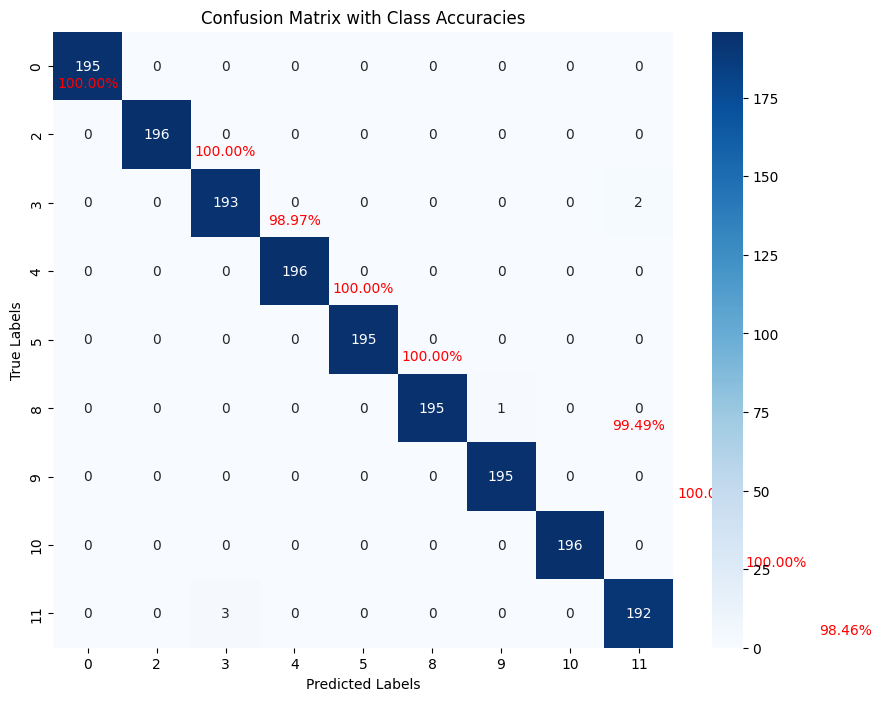

In [13]:
true_labels = _oof_df["label"].values
predicted_labels = _oof_df["preds"].values

# Get the unique classes from both true and predicted labels
classes = np.unique(np.concatenate((true_labels, predicted_labels)))
classes_ = classes
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=classes)

# Calculate accuracy for each class
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)

# Annotate cells with accuracy values
for i, j in enumerate(classes_):
    plt.text(j + 0.5, i + 0.75, f'{class_accuracies[i]*100:.2f}%', ha='center', va='center', color='red')

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix with Class Accuracies")
plt.show()

In [14]:
def train_full(df):

    # ======== SPLIT ==========
    train_folds = df.copy()
    
    # ======== DATASETS ==========
    train_dataset = CustomDataset(train_folds, is_train=True, transforms=transforms)
    
    # ======== DATALOADERS ==========
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE_TRAIN,
        shuffle=True,
        num_workers=config.NUM_WORKERS, 
        pin_memory=True, drop_last=True
    )
    
    # ======== MODEL ==========
    model = get_model(config)
    model.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.LEARNING_RATE,
        weight_decay=config.WEIGHT_DECAY
    )
    
    num_train_steps = int(len(train_folds) / config.BATCH_SIZE_TRAIN * config.EPOCHS)
    scheduler = get_scheduler(config, optimizer, num_train_steps)

    # ======= LOSS ==========
    criterion = nn.CrossEntropyLoss()
    
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.EPOCHS):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  time: {elapsed:.0f}s')
        torch.save(
            model.state_dict(),
            paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_full_train.pth"
        )

    torch.cuda.empty_cache()
    gc.collect()
    
    return _

train_full(df)

Train:   0%|          | 0/274 [00:00<?, ?train_batch/s]/tmp/ipykernel_19/596057324.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=config.AMP):
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Train:   1%|          | 2/274 [00:14<26:55,  5.94s/train_batch]  

Epoch: [1][0/274] Elapsed 0m 14s (remain 64m 48s) Loss: 2.5115 Grad: 3.6013  LR: 0.00030000  


Train: 100%|██████████| 274/274 [15:53<00:00,  3.48s/train_batch]
Epoch 1 - avg_train_loss: 0.1555  time: 954s


Epoch: [1][273/274] Elapsed 15m 53s (remain 0m 0s) Loss: 0.1555 Grad: 1.3939  LR: 0.00015043  


Train:   1%|          | 2/274 [00:13<25:48,  5.69s/train_batch]  

Epoch: [2][0/274] Elapsed 0m 13s (remain 61m 46s) Loss: 0.0056 Grad: 0.1313  LR: 0.00014957  


Train: 100%|██████████| 274/274 [15:45<00:00,  3.45s/train_batch]
Epoch 2 - avg_train_loss: 0.0205  time: 946s


Epoch: [2][273/274] Elapsed 15m 45s (remain 0m 0s) Loss: 0.0205 Grad: 0.1199  LR: 0.00000000  


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2